In [1]:
cd ..

/data/a/cpac/isultan/projects/halomassloss/core_catalog_mevolved


In [259]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import subhalo_mass_loss_model as SHMLM
import genericio as gio
from itk import hist, h5_read_dict, gio_read_dict, loadpickle, plt_latex
from plot_subhalo_mass_fn import CMF, SHMF, plotCMF, plotSHMF
from __future__ import division

In [3]:
PARTICLES100MASS = 1.148276e11 #h^-1 Msun
BOXSIZE = 256

In [4]:
plt_latex()

In [5]:
# Load 2016b Figure 5 plots
fig5a = loadpickle("Notebooks/2016b_fig5a.p") #[12,12.5]
fig5b = loadpickle("Notebooks/2016b_fig5b.p") #[13,13.5]
fig5c = loadpickle("Notebooks/2016b_fig5c.p") #[14,14.5]
fig5 = {12:fig5a, 13:fig5b, 14:fig5c}

In [6]:
def fig5_plot(M1):
    """Plot 2016B Figure 5 plot of M range [M1, M1+0.5]."""
    plotsd = fig5[np.log10(M1)]
    for k in plotsd.keys():
        plt.plot(plotsd[k][:,0][np.argsort(plotsd[k][:,1])], plotsd[k][:,1][np.argsort(plotsd[k][:,1])], '-', label=k, alpha=0.7)

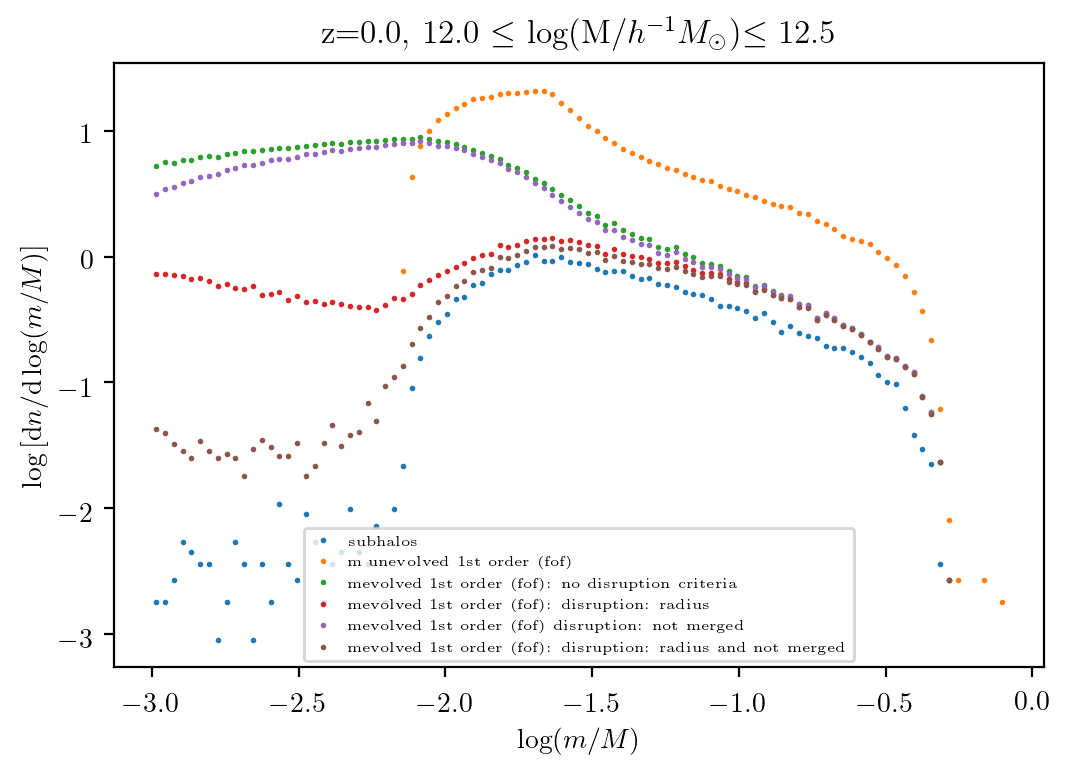

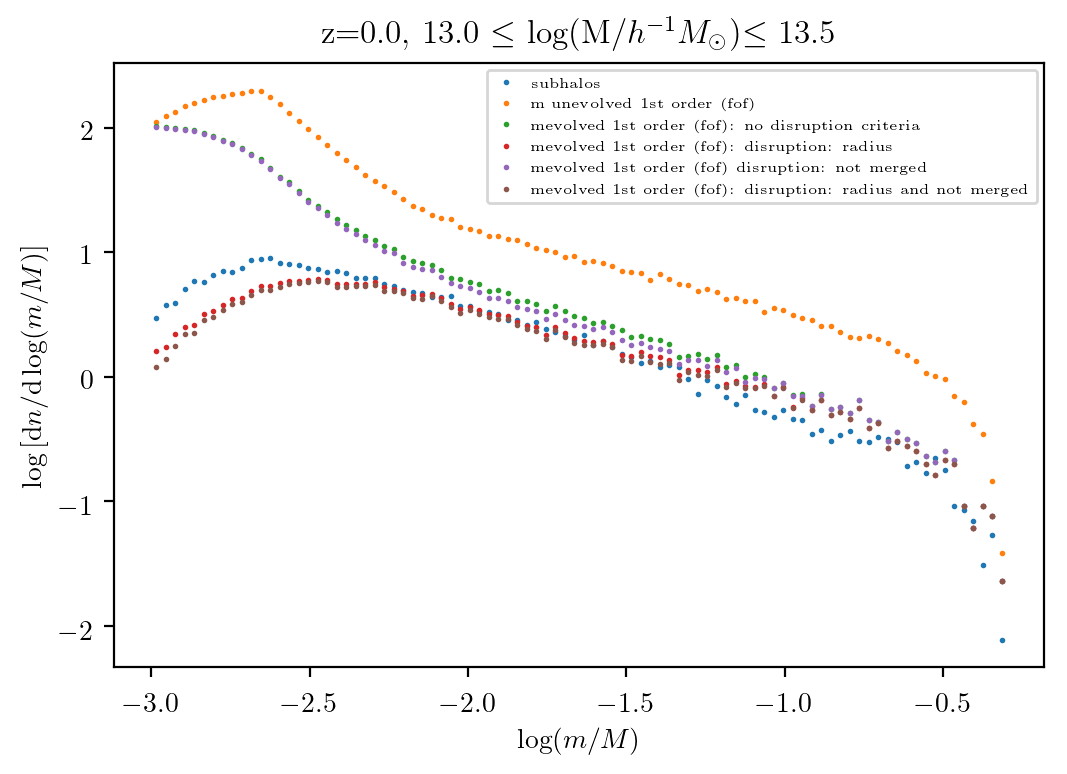

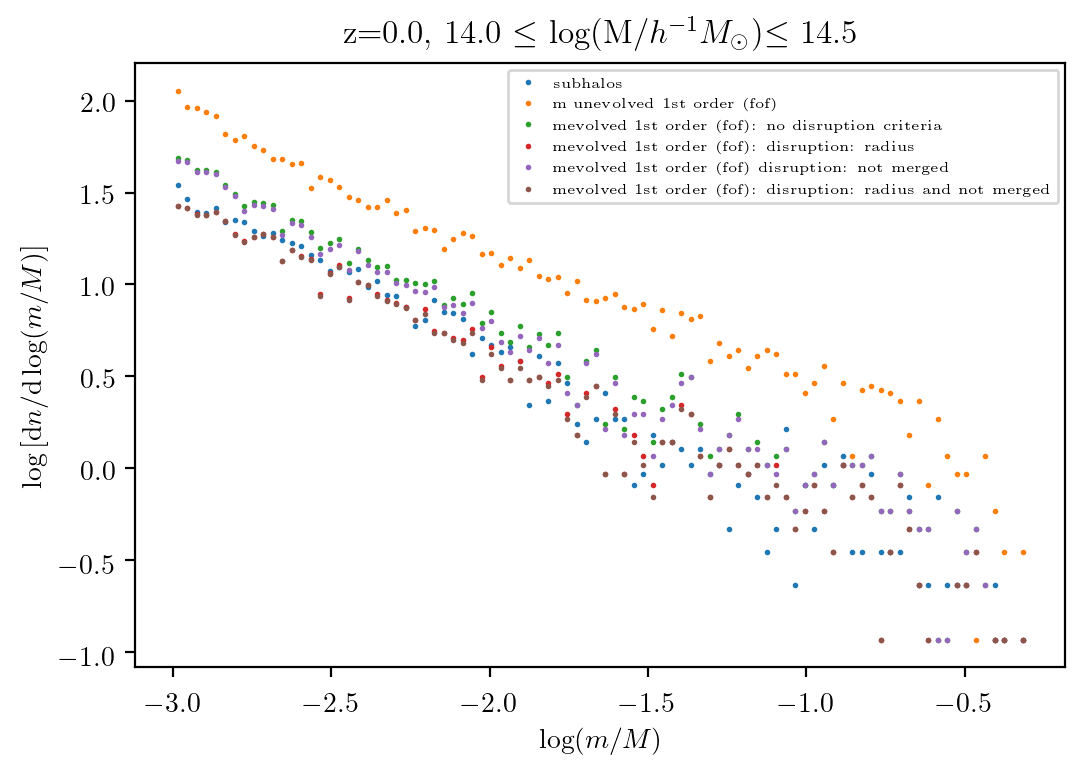

In [60]:
step=499
rall = {12:-4,13:-5,14:-6}
for M1 in [12.,13.,14.]:
#     r = (rall[M1], 0)
    r = (-3,0)
    
    M2 = M1 + 0.5
    M1 = 10**M1
    M2 = 10**M2

    plt.figure(dpi=200)
    plotSHMF(M1, M2, r)
    
    plotCMF('output_merg_fof/09_03_2019.AQ.499.corepropertiesextend.hdf5', M1, M2, s1=True, disrupt=0, returnUnevolved=True, label='m unevolved 1st order (fof)', r=r)
#     plotCMF('output_merg_fof/09_03_2019.AQ.499.corepropertiesextend.hdf5', M1, M2, s1=False, returnUnevolved=True, label='m unevolved all (fof)', r=r)
    
#     plotCMF('output_merg_virial/09_03_2019.AQ.499.corepropertiesextend.hdf5', M1, M2, s1=True, returnUnevolved=False, label='mevolved 1st order (virial)', r=r)
#     plotCMF('output_merg_virial/09_03_2019.AQ.499.corepropertiesextend.hdf5', M1, M2, s1=False, returnUnevolved=False, label='mevolved all (virial)', r=r)
    plotCMF('output_merg_fof/09_03_2019.AQ.499.corepropertiesextend.hdf5', M1, M2, s1=True, disrupt=0, returnUnevolved=False, label='mevolved 1st order (fof): no disruption criteria', r=r)
    plotCMF('output_merg_fof/09_03_2019.AQ.499.corepropertiesextend.hdf5', M1, M2, s1=True, disrupt=1, returnUnevolved=False, label='mevolved 1st order (fof): disruption: radius', r=r)
    plotCMF('output_merg_fof/09_03_2019.AQ.499.corepropertiesextend.hdf5', M1, M2, s1=True, disrupt=2, returnUnevolved=False, label='mevolved 1st order (fof) disruption: not merged', r=r)
    plotCMF('output_merg_fof/09_03_2019.AQ.499.corepropertiesextend.hdf5', M1, M2, s1=True, disrupt=411, returnUnevolved=False, label='mevolved 1st order (fof): disruption: radius and not merged', r=r)
#     plotCMF('output_merg_fof/09_03_2019.AQ.499.corepropertiesextend.hdf5', M1, M2, s1=False, returnUnevolved=False, label='mevolved all (fof)', r=r)

#     fig5_plot(M1)

    plt.xlabel(r'$\log(m/M)$')
    plt.ylabel(r'$\log \left[ \mathrm{d}n/\mathrm{d} \log(m/M) \right]$')
    plt.title( 'z=' + str(round(SHMLM.step2z[step],3)) + r', {} $\leq$ log(M/$h^{{-1}}M_\odot$)$\leq$ {}'.format(np.log10(M1),np.log10(M2)) );
    plt.legend(prop={'size': 5})
#     plt.savefig('Notebooks/figs/disruptionMF_{}.png'.format(int(np.log10(M1))))

In [212]:
cols_cc = ['fof_halo_tag', 'x', 'y', 'z', 'radius', 'infall_mass', 'central', 'host_core', 'core_tag', 'merged']

bhp = gio_read_dict('/home/isultan/data/AlphaQ/big_halo_prtcls2/m000-499.bighaloparticles', ['fof_halo_tag', 'x', 'y', 'z'])
sh = gio_read_dict('/home/isultan/data/AlphaQ/subhalos/m000-499.subhaloproperties', ['fof_halo_tag','subhalo_mean_x','subhalo_mean_y','subhalo_mean_z','subhalo_count', 'subhalo_tag', 'subhalo_mass'])
cc = gio_read_dict('/home/isultan/data/AlphaQ/core_catalog_merg/09_03_2019.AQ.499.coreproperties', cols_cc)

In [16]:
def subhalo_core_plot(fht, saveFlag=False, label='', disrupt=0, s1=False, xlim=None, ylim=None):
    fig=plt.figure(dpi= 120)
    
    if xlim is not None:
        plt.xlim(xlim)
        plt.ylim(ylim)
    
    cc_halo = { k:cc[k][cc['fof_halo_tag']==fht].copy() for k in cols_cc }
    
    central_idx = np.flatnonzero(cc_halo['central']==1)
    assert len(central_idx)==1
    fhm = cc_halo['infall_mass'][ central_idx ][0]
    central_coretag = cc_halo['core_tag'][central_idx][0]
    
#     cc_halo_mask = (cc_halo['infall_mass']>=PARTICLES100MASS)&(cc_halo['radius'] < 20e-3)&(cc_halo['central']!=1)&(cc_halo['host_core']==central_coretag)
    cc_halo_mask = (cc_halo['central']!=1)
    if s1:
        cc_halo_mask = cc_halo_mask&(cc_halo['host_core']==central_coretag)
    if disrupt != 0:
        cc_halo_mask = cc_halo_mask&SHMLM.disruption_mask(cc_halo, np.full_like(cc_halo['radius'], True, dtype=bool), criteria=disrupt)
    
    cc_halo = { k:cc_halo[k][cc_halo_mask].copy() for k in ['x', 'y', 'z'] }
    sh_halo = { k:sh[k][(sh['fof_halo_tag']==fht)&(sh['subhalo_tag']!=0)].copy() for k in ['subhalo_mean_x', 'subhalo_mean_y', 'subhalo_mean_z'] }
    bhp_halo = { k:bhp[k][bhp['fof_halo_tag']==fht].copy() for k in ['x', 'y', 'z'] }
    
    if len(cc_halo['x']) > 1:
        x_ref, y_ref = cc_halo['x'][0], cc_halo['y'][0]
        # periodic boundary conditions core mask
        cc_halo['x'] += BOXSIZE*((cc_halo['x']-x_ref)<-(BOXSIZE/2)) + -BOXSIZE*((cc_halo['x']-x_ref)>(BOXSIZE/2))
        cc_halo['y'] += BOXSIZE*((cc_halo['y']-y_ref)<-(BOXSIZE/2)) + -BOXSIZE*((cc_halo['y']-y_ref)>(BOXSIZE/2))
        # periodic boundary conditions subhalo mask
        sh_halo['subhalo_mean_x'] += BOXSIZE*((sh_halo['subhalo_mean_x']-x_ref)<-(BOXSIZE/2)) + -BOXSIZE*((sh_halo['subhalo_mean_x']-x_ref)>(BOXSIZE/2))
        sh_halo['subhalo_mean_y'] += BOXSIZE*((sh_halo['subhalo_mean_y']-y_ref)<-(BOXSIZE/2)) + -BOXSIZE*((sh_halo['subhalo_mean_y']-y_ref)>(BOXSIZE/2))
        # periodic boundary conditions bhp mask
        bhp_halo['x'] += BOXSIZE*((bhp_halo['x']-x_ref)<-(BOXSIZE/2)) + -BOXSIZE*((bhp_halo['x']-x_ref)>(BOXSIZE/2))
        bhp_halo['y'] += BOXSIZE*((bhp_halo['y']-y_ref)<-(BOXSIZE/2)) + -BOXSIZE*((bhp_halo['y']-y_ref)>(BOXSIZE/2))

    counts, xbins, ybins = np.histogram2d(bhp_halo['x'], bhp_halo['y'], bins=100)
    plt.pcolormesh(xbins, ybins, counts.T, cmap='Greys', norm=matplotlib.colors.LogNorm());
    plt.colorbar();

    plt.scatter(cc_halo['x'], cc_halo['y'], s=100, facecolors='none', edgecolors='r', label='Cores')
    plt.scatter(sh_halo['subhalo_mean_x'], sh_halo['subhalo_mean_y'], marker='x', c='b', label='Subhalos');
   
    plt.title(r'z=0, fof halo mass={}'.format(np.format_float_scientific(fhm)))
    plt.xlabel('x [$\mathrm{h^{-1}\ Mpc}$]')
    plt.ylabel('y [$\mathrm{h^{-1}\ Mpc}$]')
    plt.legend(loc=0);
    if saveFlag:
        plt.savefig('Notebooks/figs/figure{}.png'.format(fht))
        plt.close(fig)
    return plt.xlim(), plt.ylim()

In [76]:
def visdisruption(fht):
    xlim, ylim = subhalo_core_plot(fht, saveFlag=False, disrupt=0, s1=False)
    subhalo_core_plot(fht, saveFlag=False, disrupt=0, s1=True, xlim=xlim, ylim=ylim)
    subhalo_core_plot(fht, saveFlag=False, disrupt=1, s1=True, xlim=xlim, ylim=ylim)
    subhalo_core_plot(fht, saveFlag=False, disrupt=2, s1=True, xlim=xlim, ylim=ylim)
    subhalo_core_plot(fht, saveFlag=False, disrupt=411, s1=True, xlim=xlim, ylim=ylim)

In [80]:
M1, M2 = 10**12, 10**12.5
np.random.choice( cc['fof_halo_tag'][(cc['central']==1)&(M1<=cc['infall_mass'])&(cc['infall_mass']<=M2)], 5 )

array([870023866, 775079253, 351653885,  99978710, 165470439])

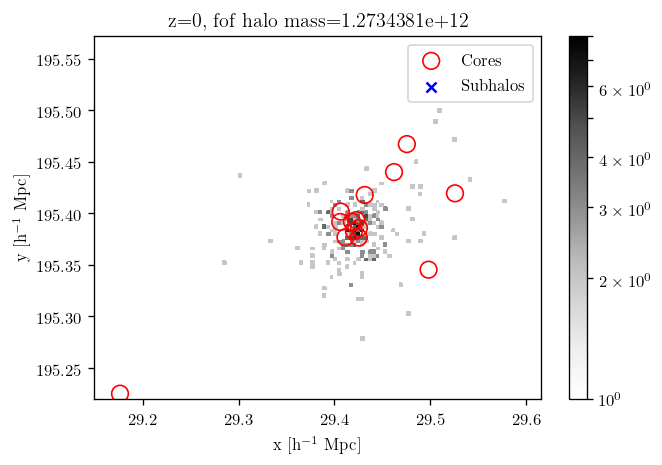

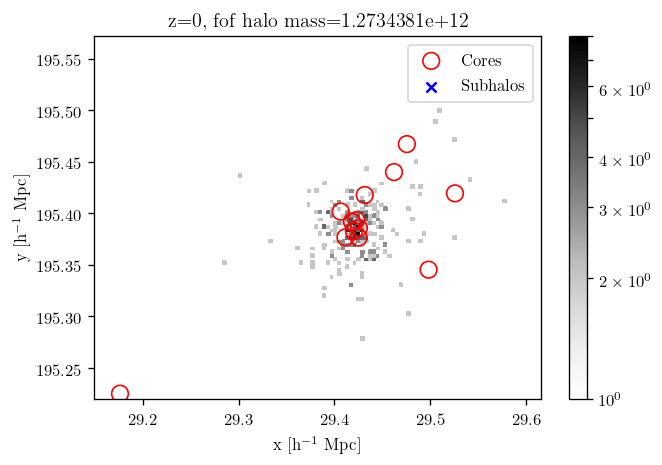

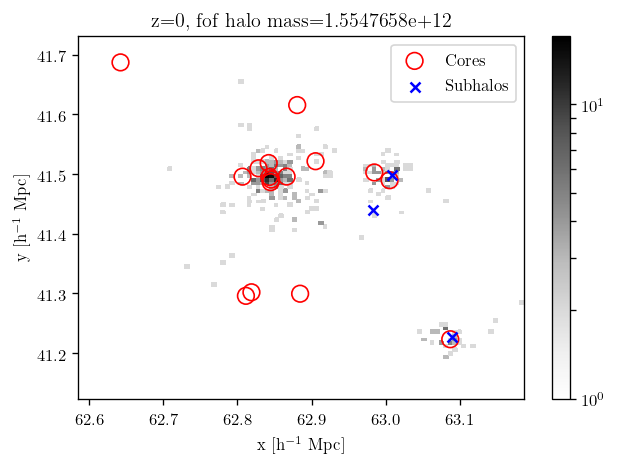

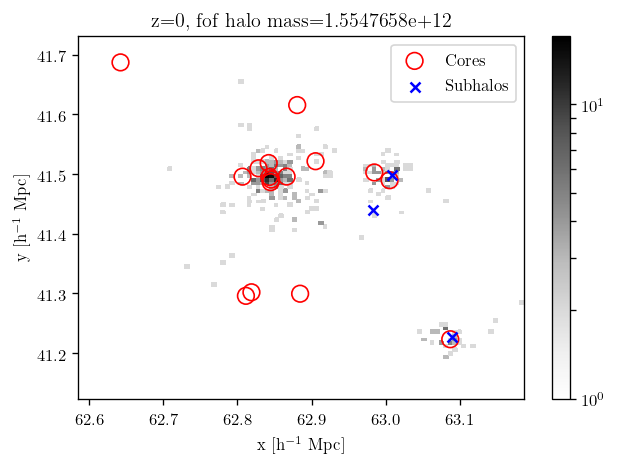

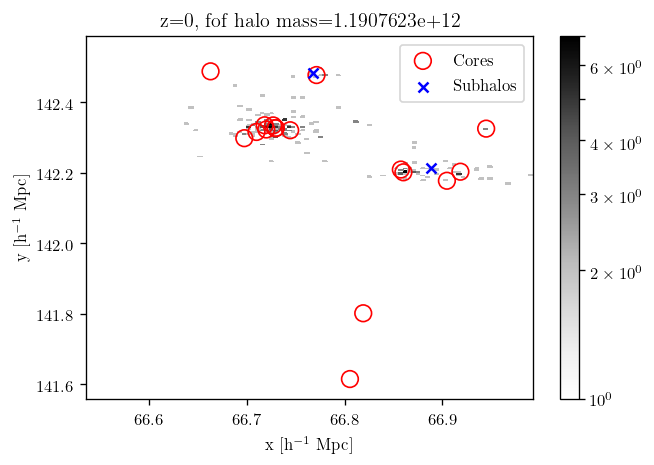

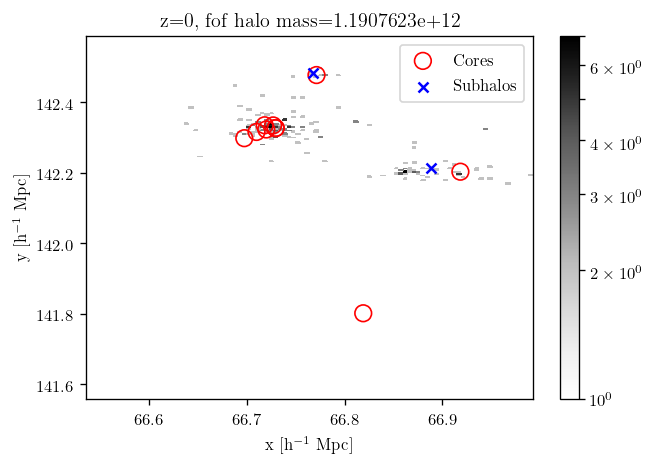

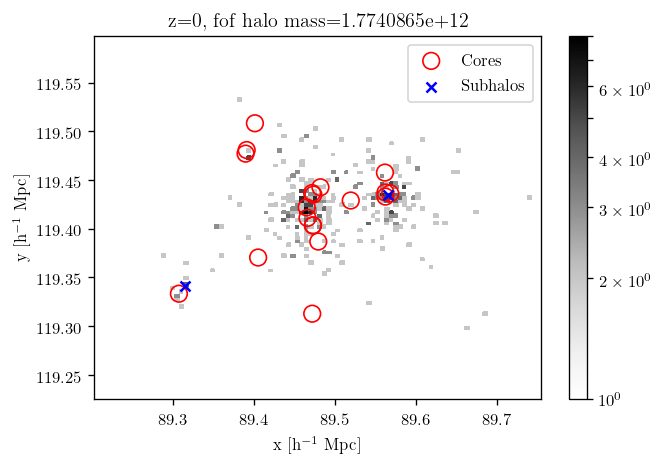

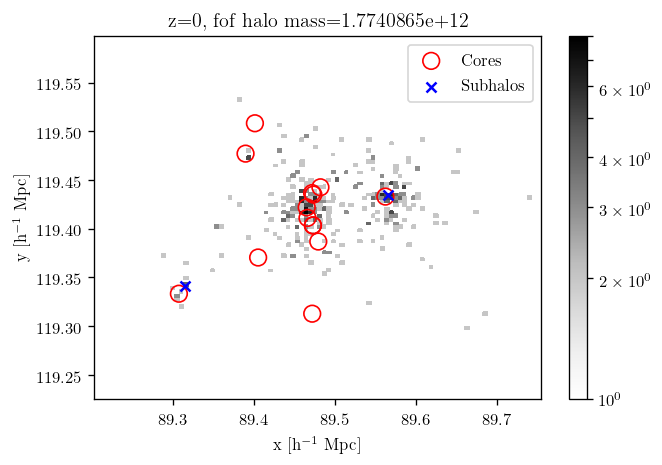

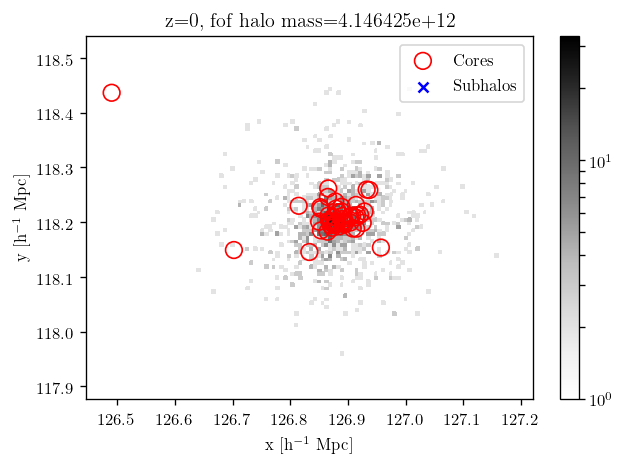

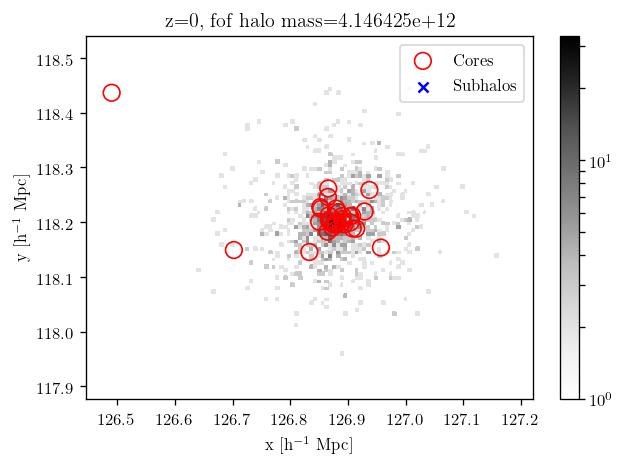

In [75]:
# 12 tags
M1, M2 = 10**12, 10**13.5
for fht in sorted(np.random.choice( cc['fof_halo_tag'][(cc['central']==1)&(M1<=cc['infall_mass'])&(cc['infall_mass']<=M2)], 5 )):
    visdisruption(fht)

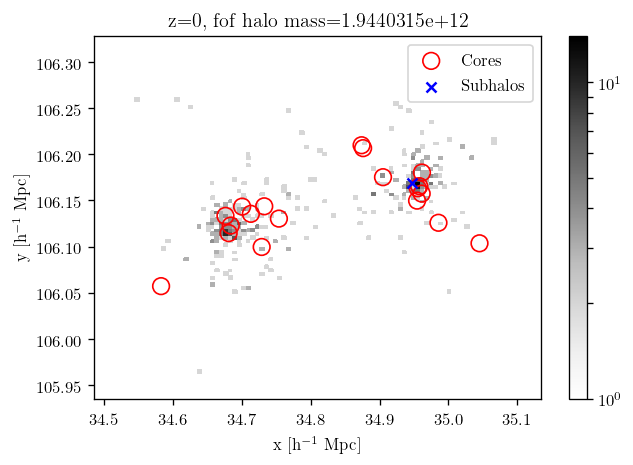

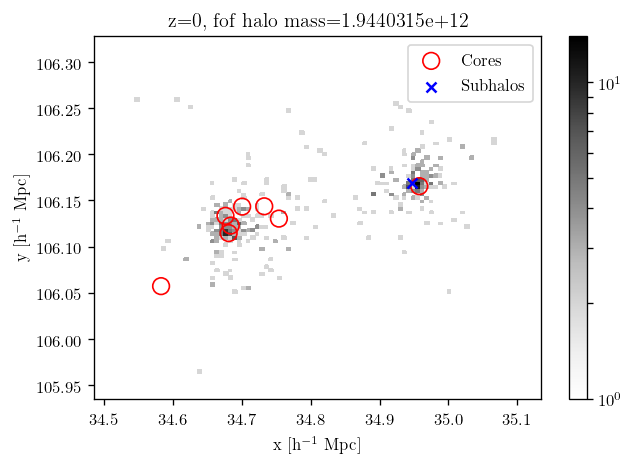

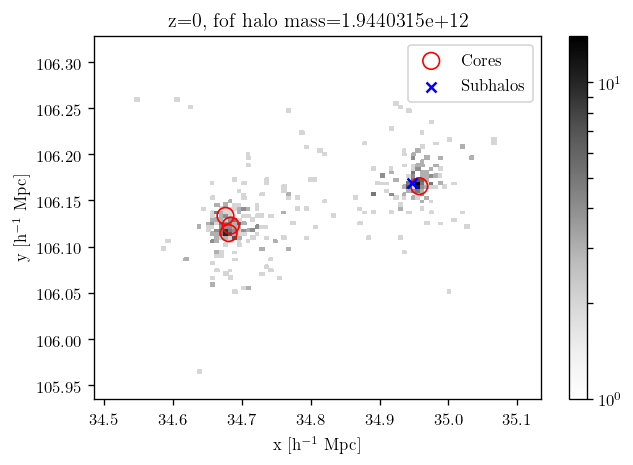

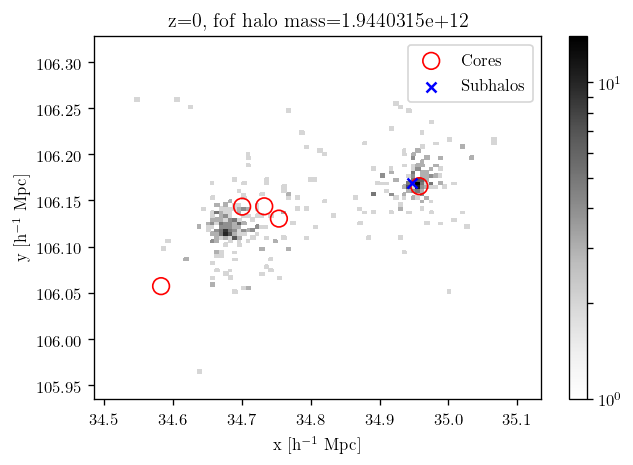

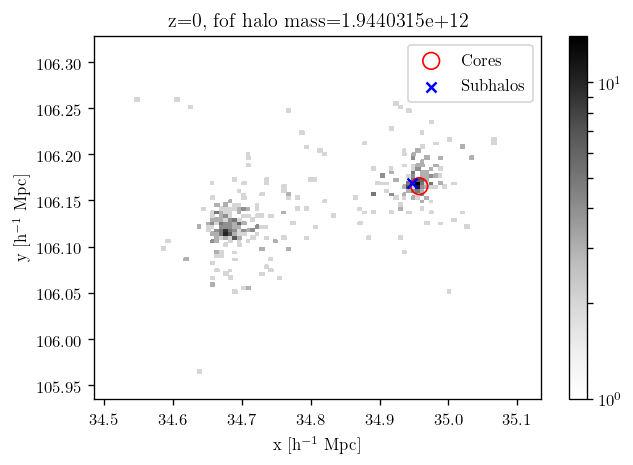

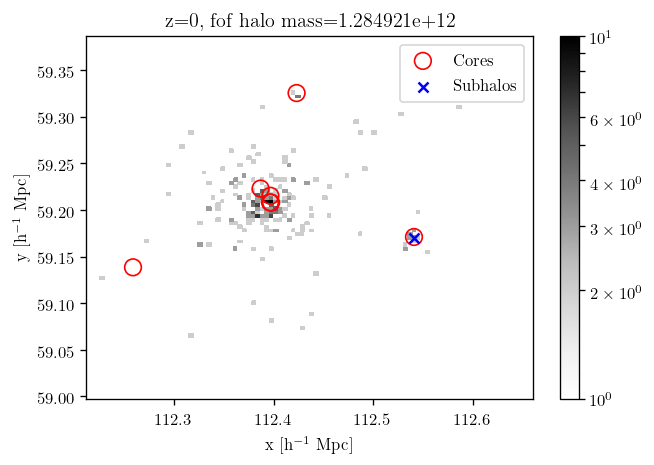

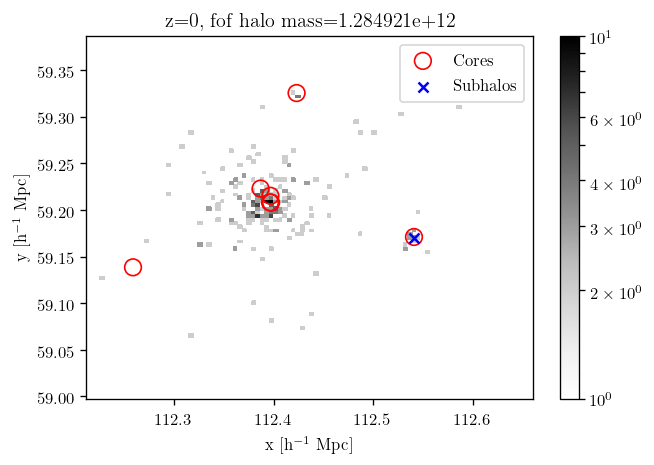

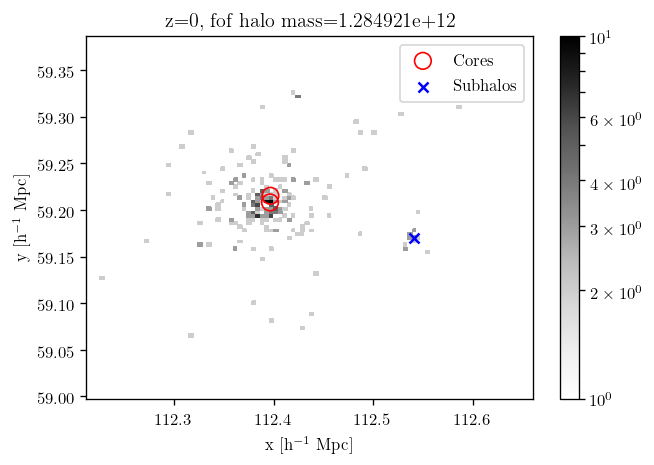

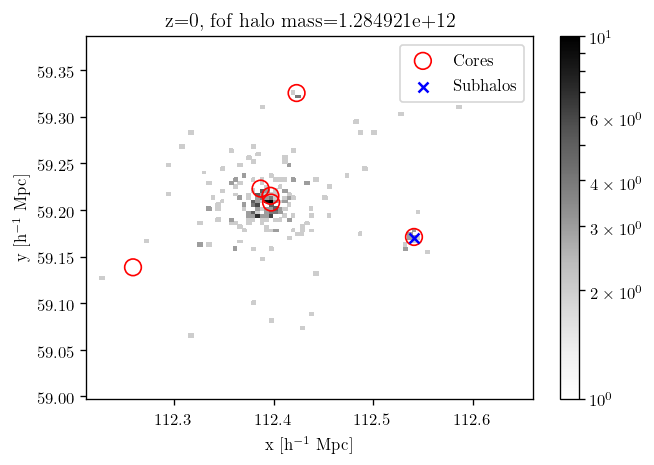

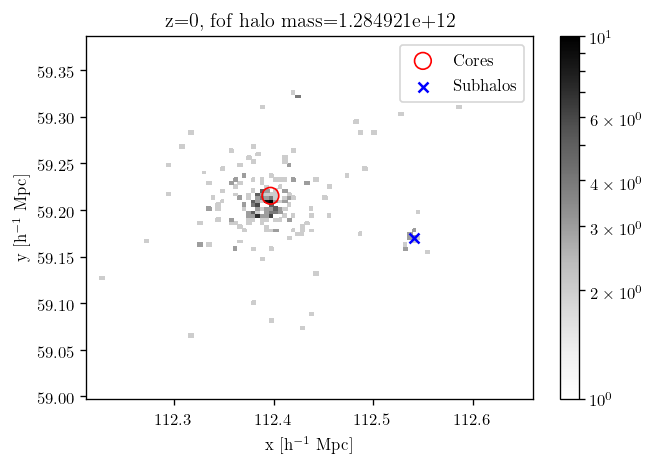

In [79]:
# 12 tags
for fht in np.array(sorted([1011920733, 393631551, 1067579619, 115756539, 238720784, 297643316, 429364955, 461607419, 464813881, 673244686, 742961773, 785424584, 807348995]))[[0,5]]:
    visdisruption(fht)

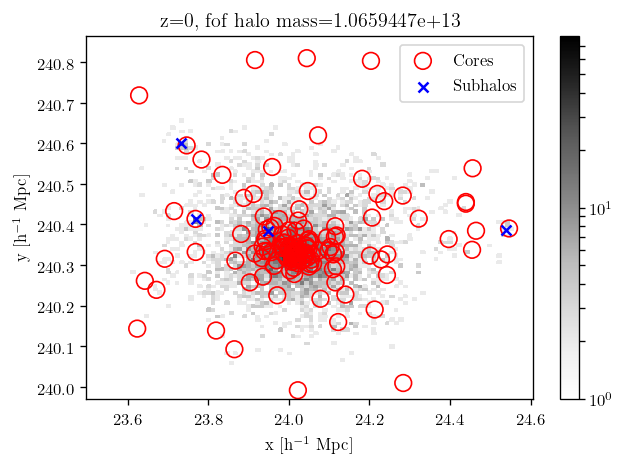

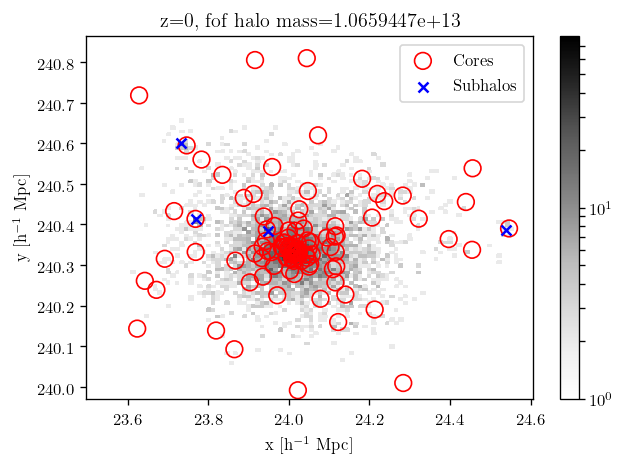

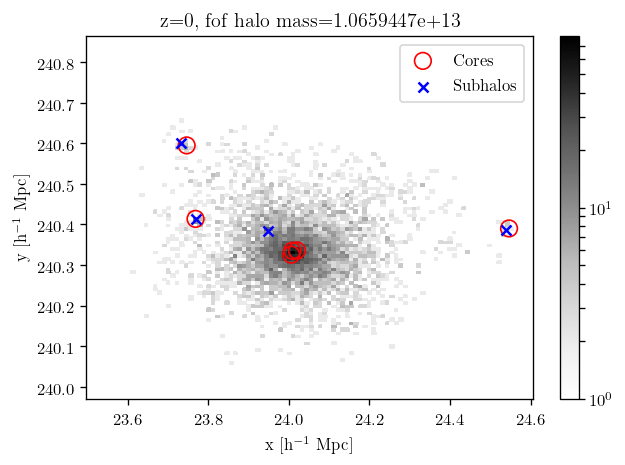

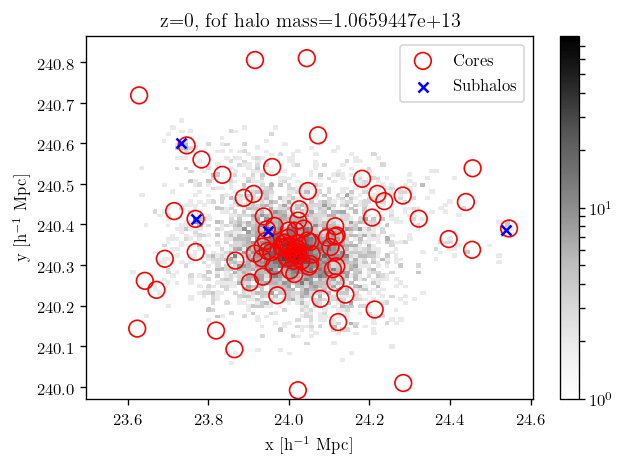

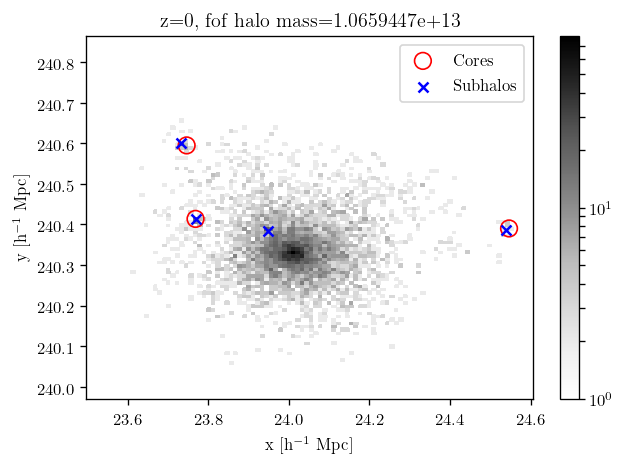

In [21]:
# 13 tags
for fht in sorted([1002483900, 135214525, 151409309, 238061426, 241511998, 288394524, 334773736, 501768777, 814229370, 816551969])[:1]:
    visdisruption(fht)

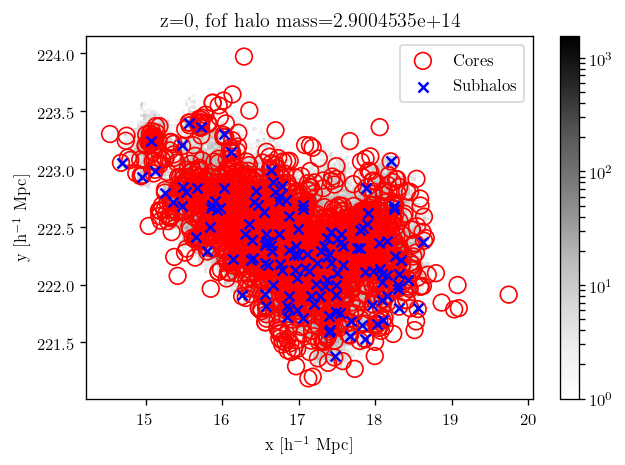

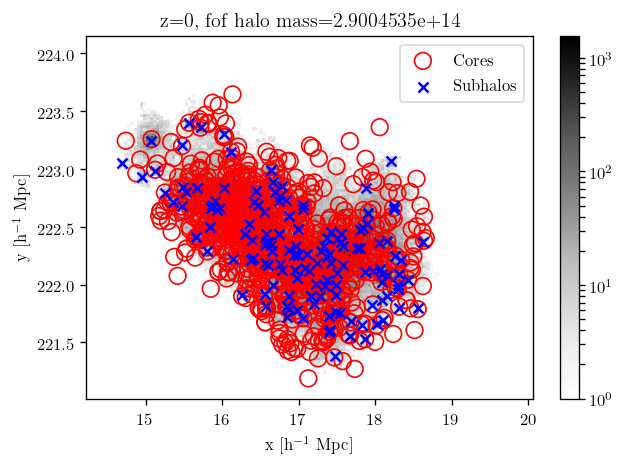

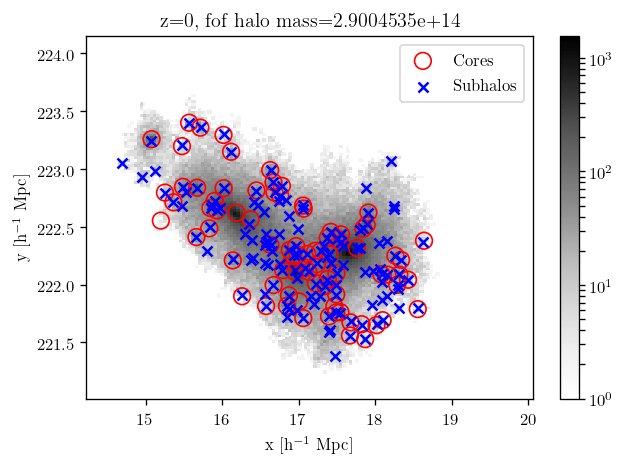

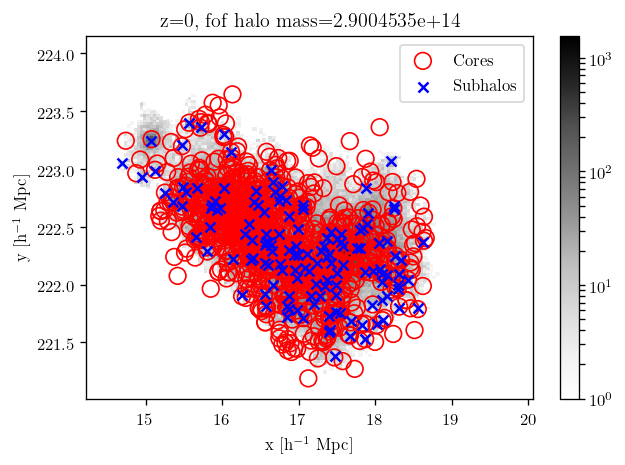

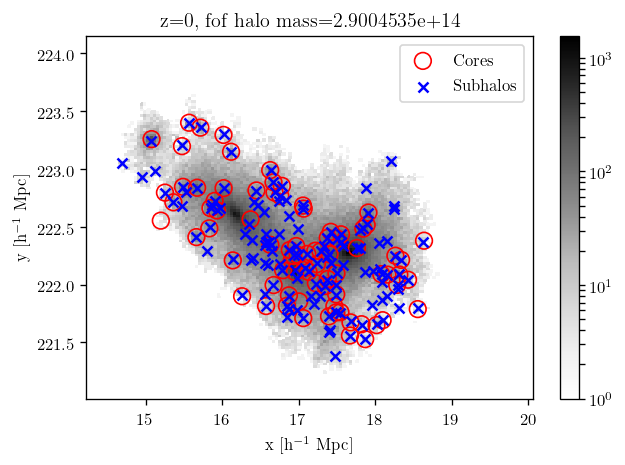

In [22]:
# 14 tags
for fht in sorted([1040287332,  757527166,  472937720,  802574311,  621261511,38685933,  112886331,  141272803,  245352048,  182027995])[:1]:
    visdisruption(fht)

In [362]:
def generate_cores_kdtree(M1, M2, s1=False, disrupt=0, fn='/home/isultan/projects/halomassloss/core_catalog_mevolved/output_merg_fof/09_03_2019.AQ.499.corepropertiesextend.hdf5'):
    from scipy import spatial #KD Tree for subhalo-core matching
    cc = h5_read_dict(fn, 'coredata')
    satellites_mask = cc['central'] == 0
    centrals_mask = cc['central'] == 1

    # Match satellites tni with centrals tni.
    vals2, idx3, idx4 = np.intersect1d( cc['tree_node_index'][satellites_mask], cc['tree_node_index'][centrals_mask], return_indices=True)

    # Unique satellites tni array with inverse indices
    vals3, idx_inv = np.unique(cc['tree_node_index'][satellites_mask], return_inverse=True)

    # Some checks
    assert np.array_equal(vals2, vals3), "All satellites don't have a central match."
    assert np.array_equal(vals3[idx_inv], cc['tree_node_index'][satellites_mask]), 'np.unique inverse indices: original array recreation failure'
    assert np.array_equal(cc['tree_node_index'][centrals_mask][idx4], np.sort(cc['tree_node_index'][centrals_mask][idx4])), 'Centrals with satellites: array sorting failure'

    # Create M array (corresponds with cc[satellites_mask]) to be host tree node mass of each satellite
    M = cc['infall_mass'][centrals_mask][idx4][idx_inv]

#     mask = np.flatnonzero( np.full_like(M, True, bool) )
    mask = np.flatnonzero( (M1 <= M) & (M <= M2) )#& (cc['infall_mass'][satellites_mask] >= SHMLM.PARTICLES100MASS) )
    if s1:
        Coretag = cc['core_tag'][centrals_mask][idx4][idx_inv]
        mask = np.intersect1d( mask, np.flatnonzero(cc['host_core'][satellites_mask]==Coretag) )
    if disrupt != 0:
        mask = np.intersect1d( mask, np.flatnonzero(SHMLM.disruption_mask(cc, satellites_mask, disrupt)) )

    return spatial.KDTree( np.vstack((cc['x'][satellites_mask][mask], cc['y'][satellites_mask][mask], cc['z'][satellites_mask][mask])).T ), { k:cc[k][satellites_mask][mask].copy() for k in cc.keys() }

In [414]:
cores_tree, cc_filtered = generate_cores_kdtree(M1=10**9, M2=10**15.5, s1=False, disrupt=411)

In [415]:
sh_mask = (sh['subhalo_tag']!=0)
sh_arr = np.vstack((sh['subhalo_mean_x'][sh_mask], sh['subhalo_mean_y'][sh_mask], sh['subhalo_mean_z'][sh_mask])).T

In [416]:
dist, idx = cores_tree.query(sh_arr, k=2, distance_upper_bound=0.1)

In [417]:
f1, f2 = (dist != np.inf).T

In [425]:
fmask = f1^f2

In [426]:
plotarr = sh['subhalo_mass'][sh_mask][fmask] / cc_filtered['m_evolved'][idx[:,0][fmask]]

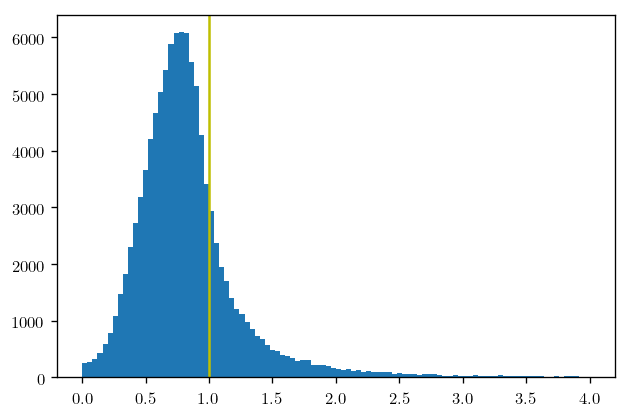

In [427]:
plt.hist(plotarr, range=(0,4), bins=100);
plt.axvline(x=1, c='y')

In [428]:
np.sum(fmask)/np.sum(sh_mask)*100

65.69961585779205

In [429]:
f1i, f2i = f1[np.invert(fmask)], f2[np.invert(fmask)]

In [430]:
np.sum(f1i)/len(f1i)*100

23.061157266771584

In [431]:
np.sum(np.invert(f1i))/len(f1i)*100

76.93884273322841

In [ ]:
55.2%, 79%, 21%